# TASK 2 - 

### Deliverables :



1. Make a quantum addtion circuit using the draper's QFT-based [algorithm](https://arxiv.org/abs/quant-ph/0008033). Make sure that it works, check by seeing counts against the correct bit string.

\
2. Build a function with input,and QuantumCircuit where:\
    $\alpha$ → Probability of having a random Pauli operator acting on the qubit after a one-qubit gate \
    $\beta$ → Probability of having a random Pauli operator acting on the qubit after a two-qubit gate \
    QuantumCircuit → Quantum circuit where the noise will be added 
The output should be the Quantum Circuit with Noise 

\
3. Quantum computers can implement only a set of gates that, with transformations, can represent any other possible gate. This set of gates is called the Gate Basis of the QPU. Build a function that transforms a general Quantum Circuit to the following gate basis: {CX,ID,RZ,SX,X}

\
4. Now, we can combine all the functions. Transform the circuit used in the quantum_sum to the gate basis and add noise. Use different levels of noise and analyze the results. \
    a. How does the noise affect the results? \
    b. Is there a way to decrease the effect of noise? \
    c. How does the number of gates used affect the results?

# Draper Addition circuit with artificial random noise

In [97]:
import numpy as np
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.quantum_info import Pauli, Statevector, state_fidelity
from qiskit.circuit import Gate
from qiskit.circuit.library import XGate, YGate, ZGate, CXGate, CYGate, CZGate
from qiskit_aer import AerSimulator, StatevectorSimulator, Aer
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt

### QFT and IQFT

In [59]:
def qft(circuit,n):
    n = circuit.num_qubits
    for i in range(n):
        circuit.h(i)
        for j in range(i + 1, n):
            circuit.cp(np.pi / 2**(j - i), j, i)
        #circuit.barrier()
    #for i in range(n // 2):
        #circuit.swap(i, n - i - 1)
    return circuit

def iqft(circuit,n):
    n = circuit.num_qubits
    circuit = qft(circuit,n)
    return circuit.inverse()

# DRAPER FUNCTION

In [60]:
def quantum_sum(a, b, n):
    circuit = QuantumCircuit(n*2, n)
    #init the states
    for i in range(n):
        if (a >> i) & 1:
            circuit.x(n-i-1)
        if (b >> i) & 1:
            circuit.x(n-(i + n)-1)
    
    qft_op = QuantumCircuit(n,name="qft")
    qft_op = qft(qft_op,n)
    qft_op.to_gate()
    circuit.append(qft_op,list(range(n,2*n))) 
    
    for i in range(n):
        for j in range(i, n):
            circuit.cp(np.pi / 2**(j - i), j, i+n)
            
    iqft_op = QuantumCircuit(n,name="iqft")
    iqft_op = iqft(iqft_op,n)
    iqft_op.to_gate()
    circuit.append(iqft_op,list(range(n,2*n)))
    
    l = list(range(2*n))
    circuit.measure(l[-n:][::-1], l[:n])
    return circuit

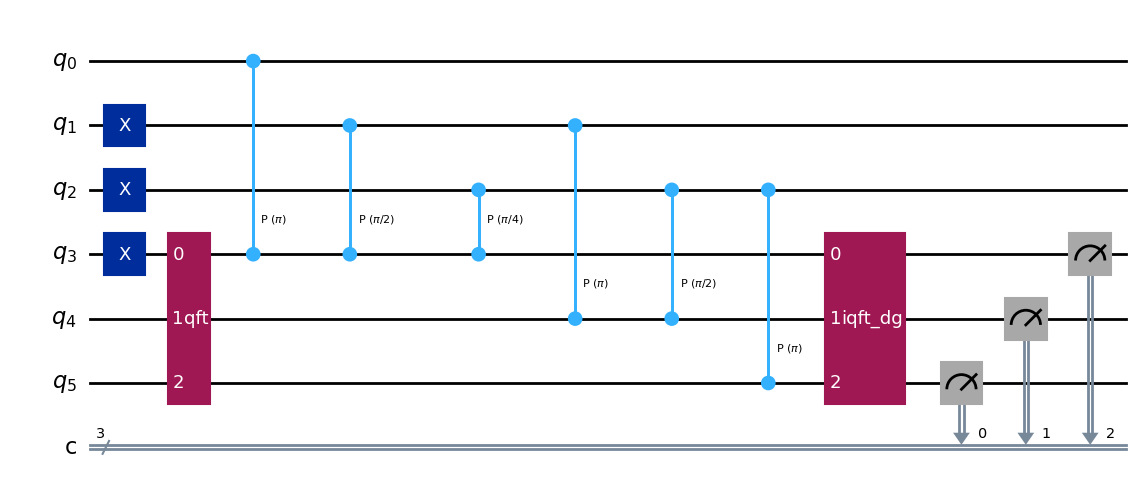

In [61]:
qc = quantum_sum(3, 4, 3)
qc.draw('mpl')

In [62]:
basis = ['cx', 'id', 'rz', 'sx', 'x']
print(f"Number 1 : {3},{format(3,'b')}") 
print(f"Number 2 : {4},{format(4,'b')}")
print(f"Expected result : {3+4}, {format(3+4,'b')}")
print(f"Number of bits reqd : {len(format(3+4,'b'))}")

Number 1 : 3,11
Number 2 : 4,100
Expected result : 7, 111
Number of bits reqd : 3


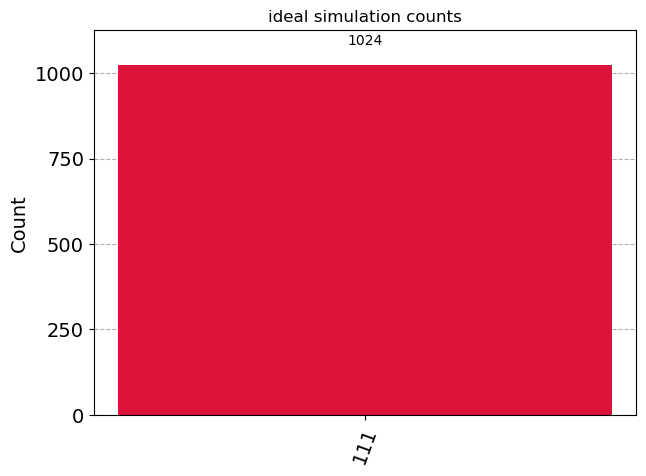

In [63]:
sim = AerSimulator()
transpiled = transpile(qc, sim, basis_gates=basis, optimization_level=2)
result = sim.run(transpiled).result()
counts_ideal = result.get_counts()
plot_histogram(counts_ideal, color='crimson', title= "ideal simulation counts")

4 + 3 = 7

$|100\rangle + |011\rangle = |111\rangle$

Correct answer! Let's try for bigger numbers

In [64]:
#proof
list(dict(counts_ideal).keys())[0], list(dict(counts_ideal).keys())[0] == format(3+4,'b')

('111', True)

## Example 2 - 4 bit numbers

In [65]:
qc = quantum_sum(8,6,4)
print(f"Number 1 : {8},{format(8,'b')}") 
print(f"Number 2 : {6},{format(6,'b')}")
print(f"Expected result : {8+6},{format(8+6,'b')}")
print(f"Number of bits reqd : {len(format(8+6,'b'))}")

Number 1 : 8,1000
Number 2 : 6,110
Expected result : 14,1110
Number of bits reqd : 4


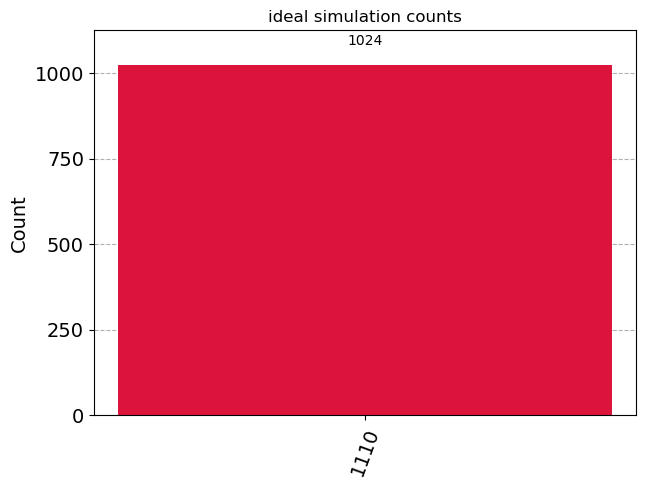

In [66]:
sim = AerSimulator()
transpiled = transpile(qc, sim, basis_gates=basis, optimization_level=2)
result = sim.run(transpiled).result()
counts_ideal = result.get_counts()
plot_histogram(counts_ideal, color='crimson', title= "ideal simulation counts")

8 + 6 = 14

$|1000\rangle + |0110\rangle = |1110\rangle$

Again correct answer!

In [67]:
#proof
list(dict(counts_ideal).keys())[0], list(dict(counts_ideal).keys())[0] == format(8+6,'b')

('1110', True)

## Example 3 - 8 bit numbers

In [68]:
qc = quantum_sum(129,59,8)
print(f"Number 1 : {129},{format(129,'b')}") 
print(f"Number 2 : {59},{format(59,'b')}")
print(f"Expected result : {129+59}, {format(129+59,'b')}")
print(f"Number of bits reqd : {len(format(129+59,'b'))}")

Number 1 : 129,10000001
Number 2 : 59,111011
Expected result : 188, 10111100
Number of bits reqd : 8


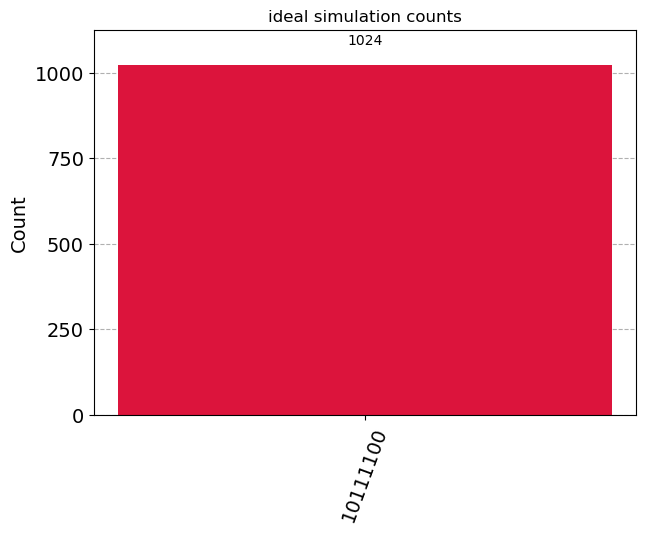

In [69]:
sim = AerSimulator()
transpiled = transpile(qc, sim, basis_gates=basis, optimization_level=2)
result = sim.run(transpiled).result()
counts_ideal = result.get_counts()
plot_histogram(counts_ideal, color='crimson', title= "ideal simulation counts")

We can now add **8 bit** digits as well !
129 + 59 = 188

$|10000001\rangle +  |00111011\rangle = |10111100\rangle)$

In [70]:
#proof
list(dict(counts_ideal).keys())[0], list(dict(counts_ideal).keys())[0] == format(129+59,'b')

('10111100', True)

## Example 4 - Let's test for 10 bit digits!

In [71]:
qc = quantum_sum(1000,19,10)
print(f"Number 1 : {1000},{format(1000,'b')}, Number 2 : {19},{format(19,'b')}, Expected result : {1000+19}, {format(1000+19,'b')}")

Number 1 : 1000,1111101000, Number 2 : 19,10011, Expected result : 1019, 1111111011


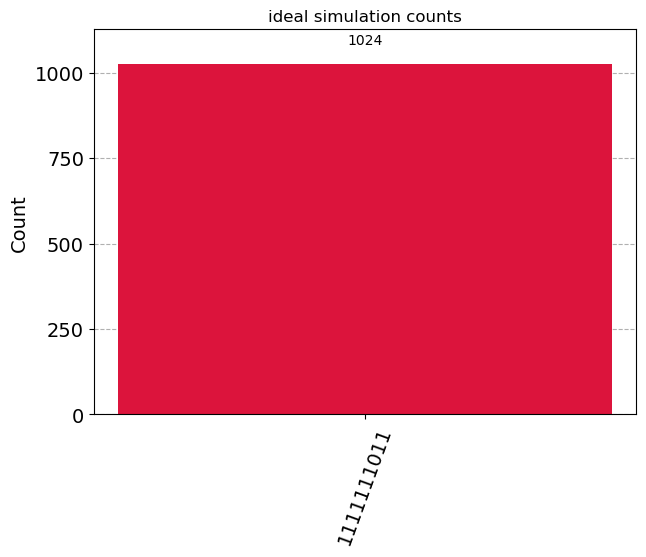

In [72]:
sim = AerSimulator()
transpiled = transpile(qc, sim, optimization_level=2)
result = sim.run(transpiled).result()
counts_ideal = result.get_counts()
plot_histogram(counts_ideal, color='crimson', title= "ideal simulation counts")

In [73]:
list(dict(counts_ideal).keys())[0], list(dict(counts_ideal).keys())[0] == format(1000+19,'b')

('1111111011', True)

# Noise simulation

### Adding artificially inserted noise

In [86]:
def quantum_sum(a, b, n):
    circuit = QuantumCircuit(n*2, n)
    for i in range(n):
        if (a >> i) & 1:
            circuit.x(n-i-1)
        if (b >> i) & 1:
            circuit.x(n-(i + n)-1)
    qft_op = QuantumCircuit(n,name="qft")
    qft_op = qft(qft_op,n)
    qft_op.to_gate()
    circuit.append(qft_op,list(range(n,2*n)))
    for i in range(n):
        for j in range(i, n):
            circuit.cp(np.pi / 2**(j - i), j, i+n)
    iqft_op = QuantumCircuit(n,name="iqft")
    iqft_op = iqft(iqft_op,n)
    iqft_op.to_gate()
    circuit.append(iqft_op,list(range(n,2*n)))
    return circuit

pauli_gates = {'X': XGate(), 'Y': YGate(), 'Z': ZGate()}
controlled_pauli_gates = {'CX': CXGate(), 'CY': CYGate(), 'CZ': CZGate()}

def add_noise(circuit, alpha, beta, n):
    noisy_circuit = QuantumCircuit(2*n, n)
    for instr, qargs, _ in circuit:
        noisy_circuit.append(instr, qargs)
        noise_prob = alpha if instr.num_qubits == 1 else beta
        if np.random.rand() < noise_prob and instr.num_qubits == 1:
            noise_gate = pauli_gates[np.random.choice(['X', 'Y', 'Z'])]
            noisy_circuit.append(noise_gate, [qargs[0]])
        elif instr.num_qubits == 2 and np.random.rand() < beta:
            noise_gate = controlled_pauli_gates[np.random.choice(['CX', 'CY', 'CZ'])]
            noisy_circuit.append(noise_gate, qargs)
    return noisy_circuit

def measurements(qc,n):
    l = list(range(2*n))
    qc.measure(l[-n:][::-1], l[:n])
    return qc

In [87]:
ideal = measurements(quantum_sum(3, 11, 5),5)
with_noise = measurements(add_noise(quantum_sum(3, 11, 5), alpha=0.4, beta=0.27, n=5),5)

#### Comparison between structure of circuits

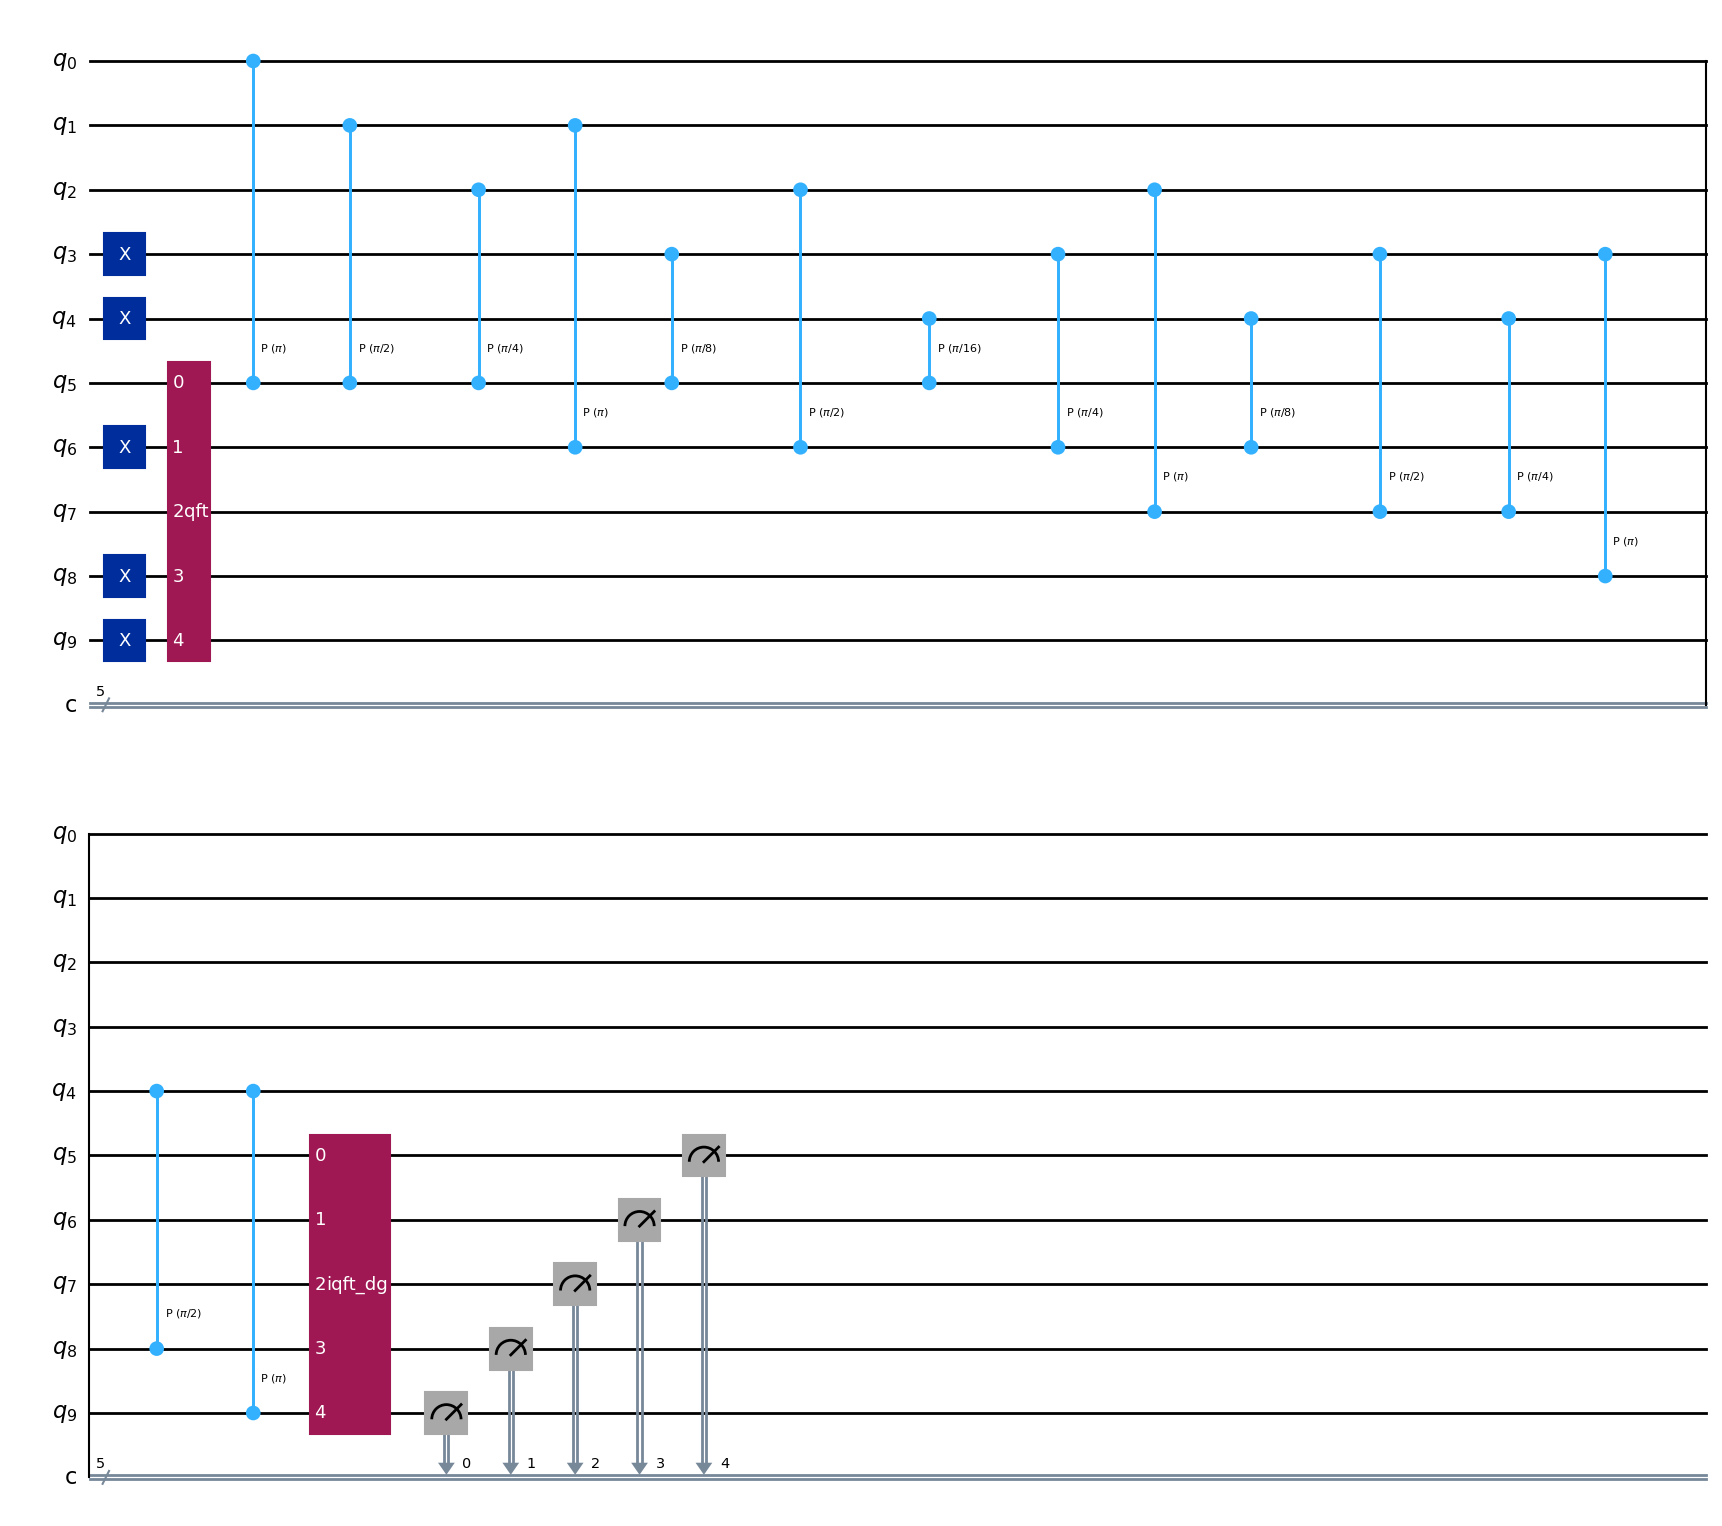

In [88]:
ideal.draw('mpl')

SPOT THE DIFFERENCES BETWEEN THE TWO


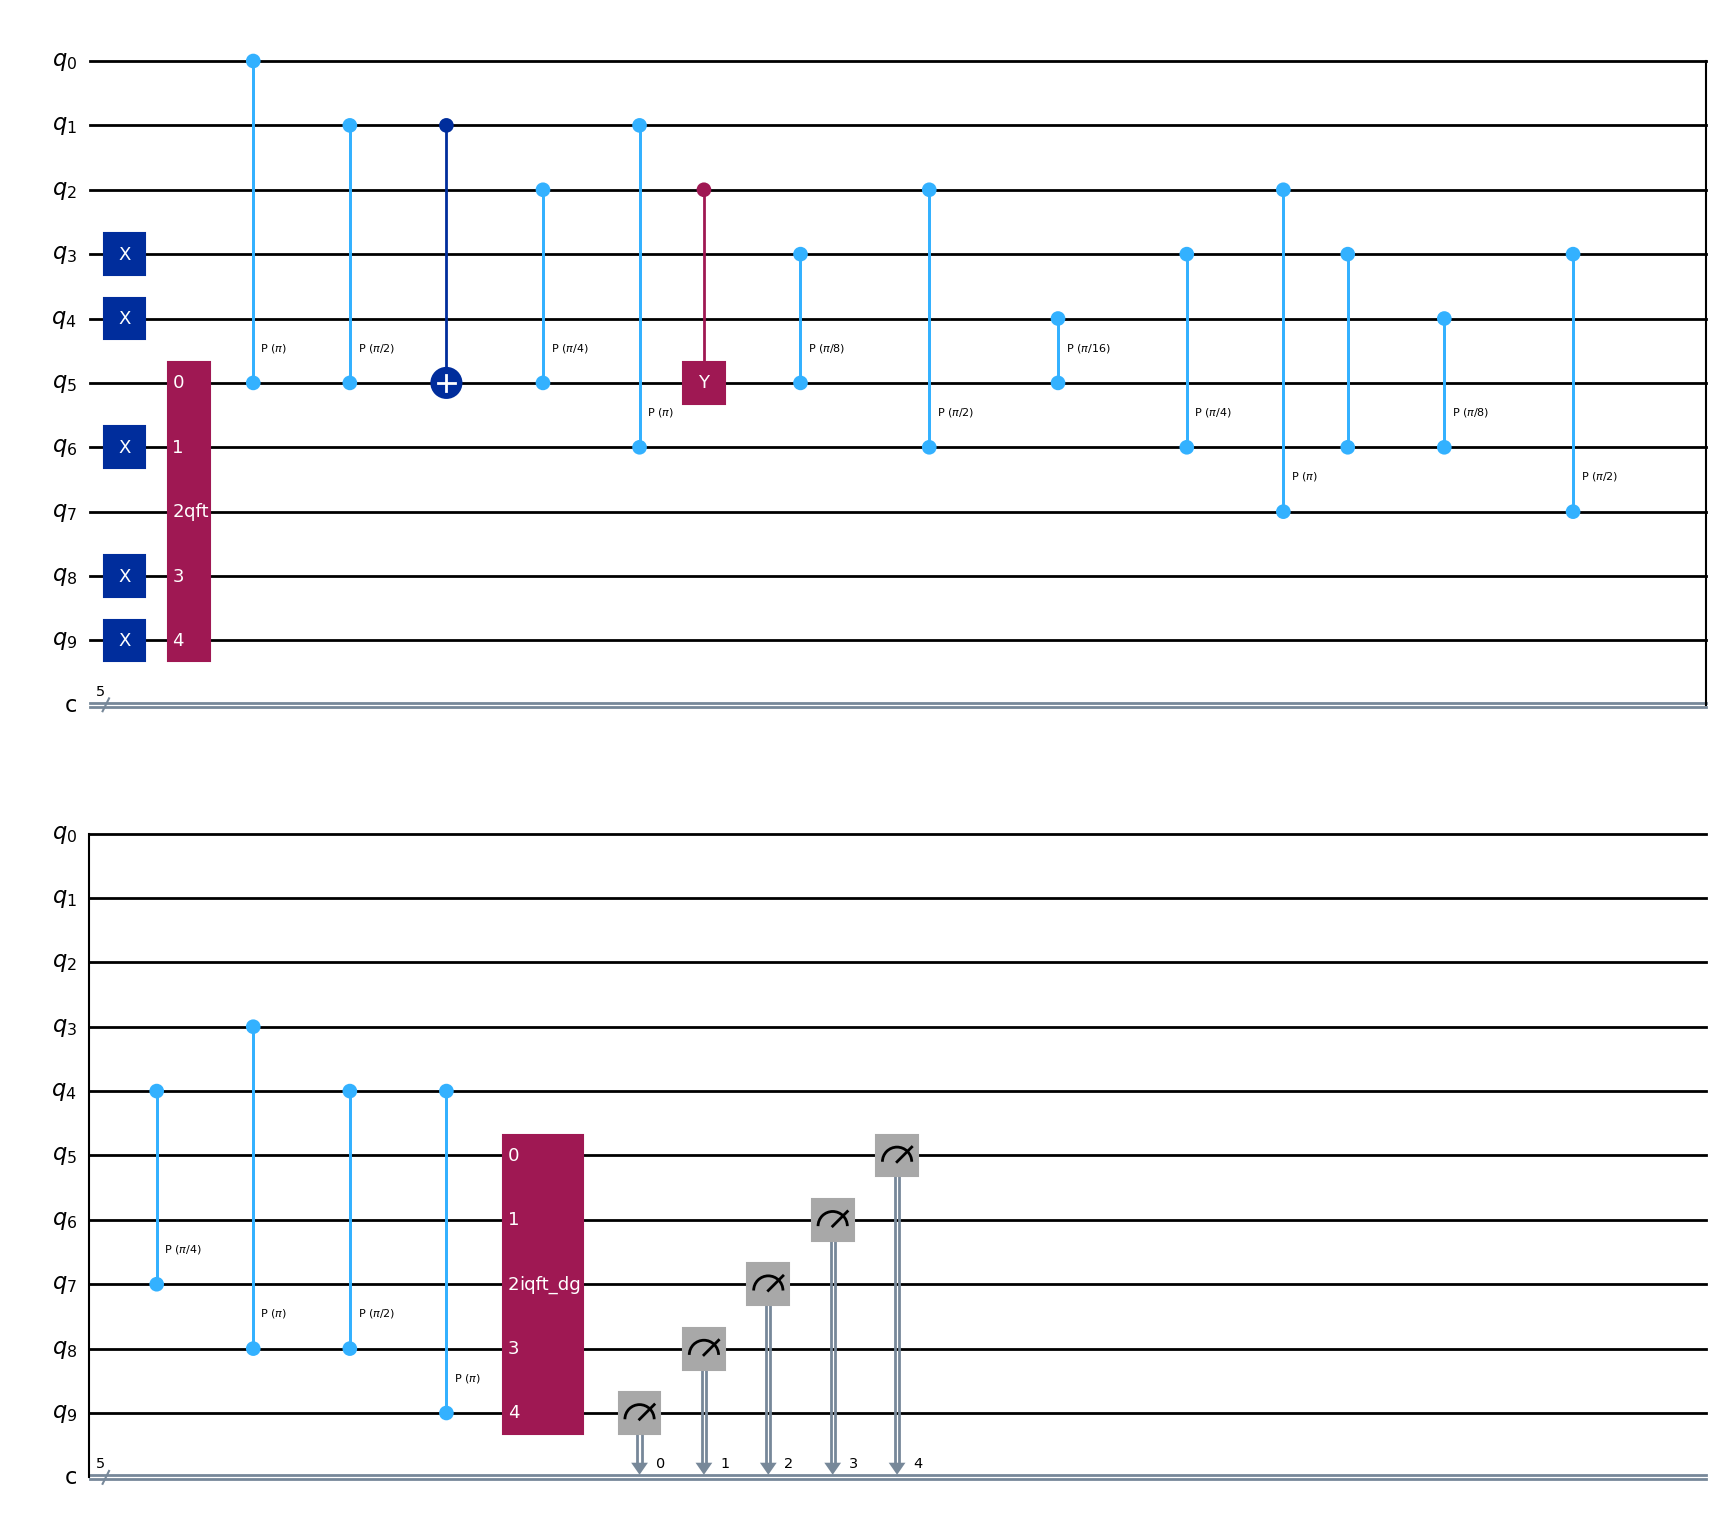

In [89]:
print("SPOT THE DIFFERENCES BETWEEN THE TWO")
with_noise.draw('mpl')

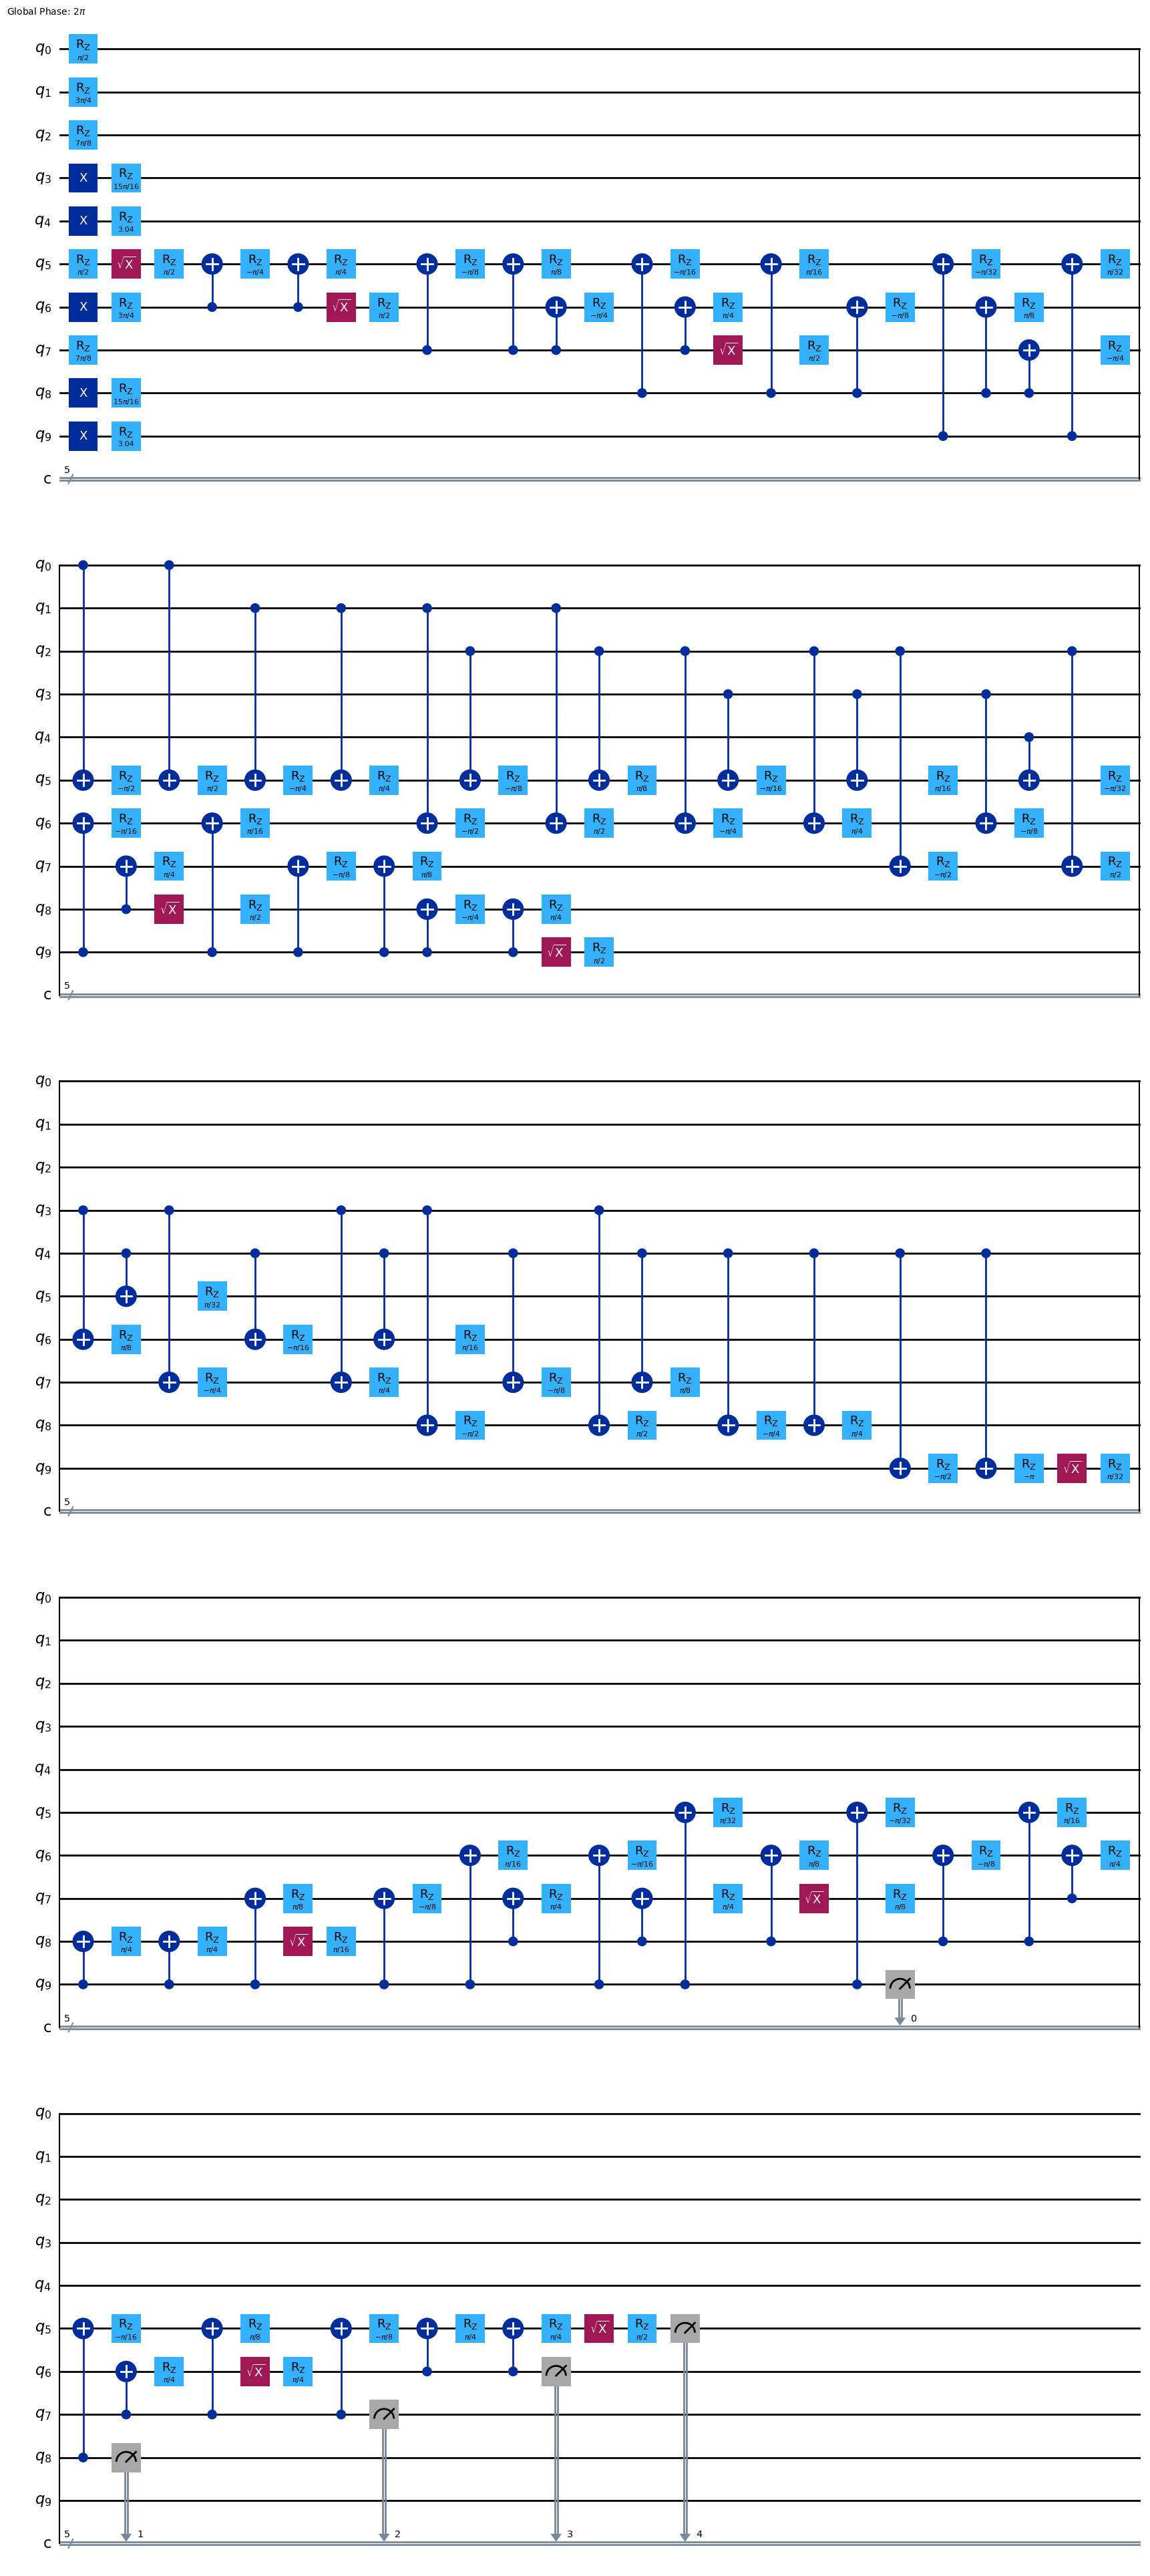

In [90]:
transpiled1 = transpile(ideal, sim, basis_gates=basis, optimization_level=2)
transpiled2 = transpile(with_noise, sim, basis_gates=basis, optimization_level=2)
transpiled1.draw('mpl') # in gate basis of the system qpu

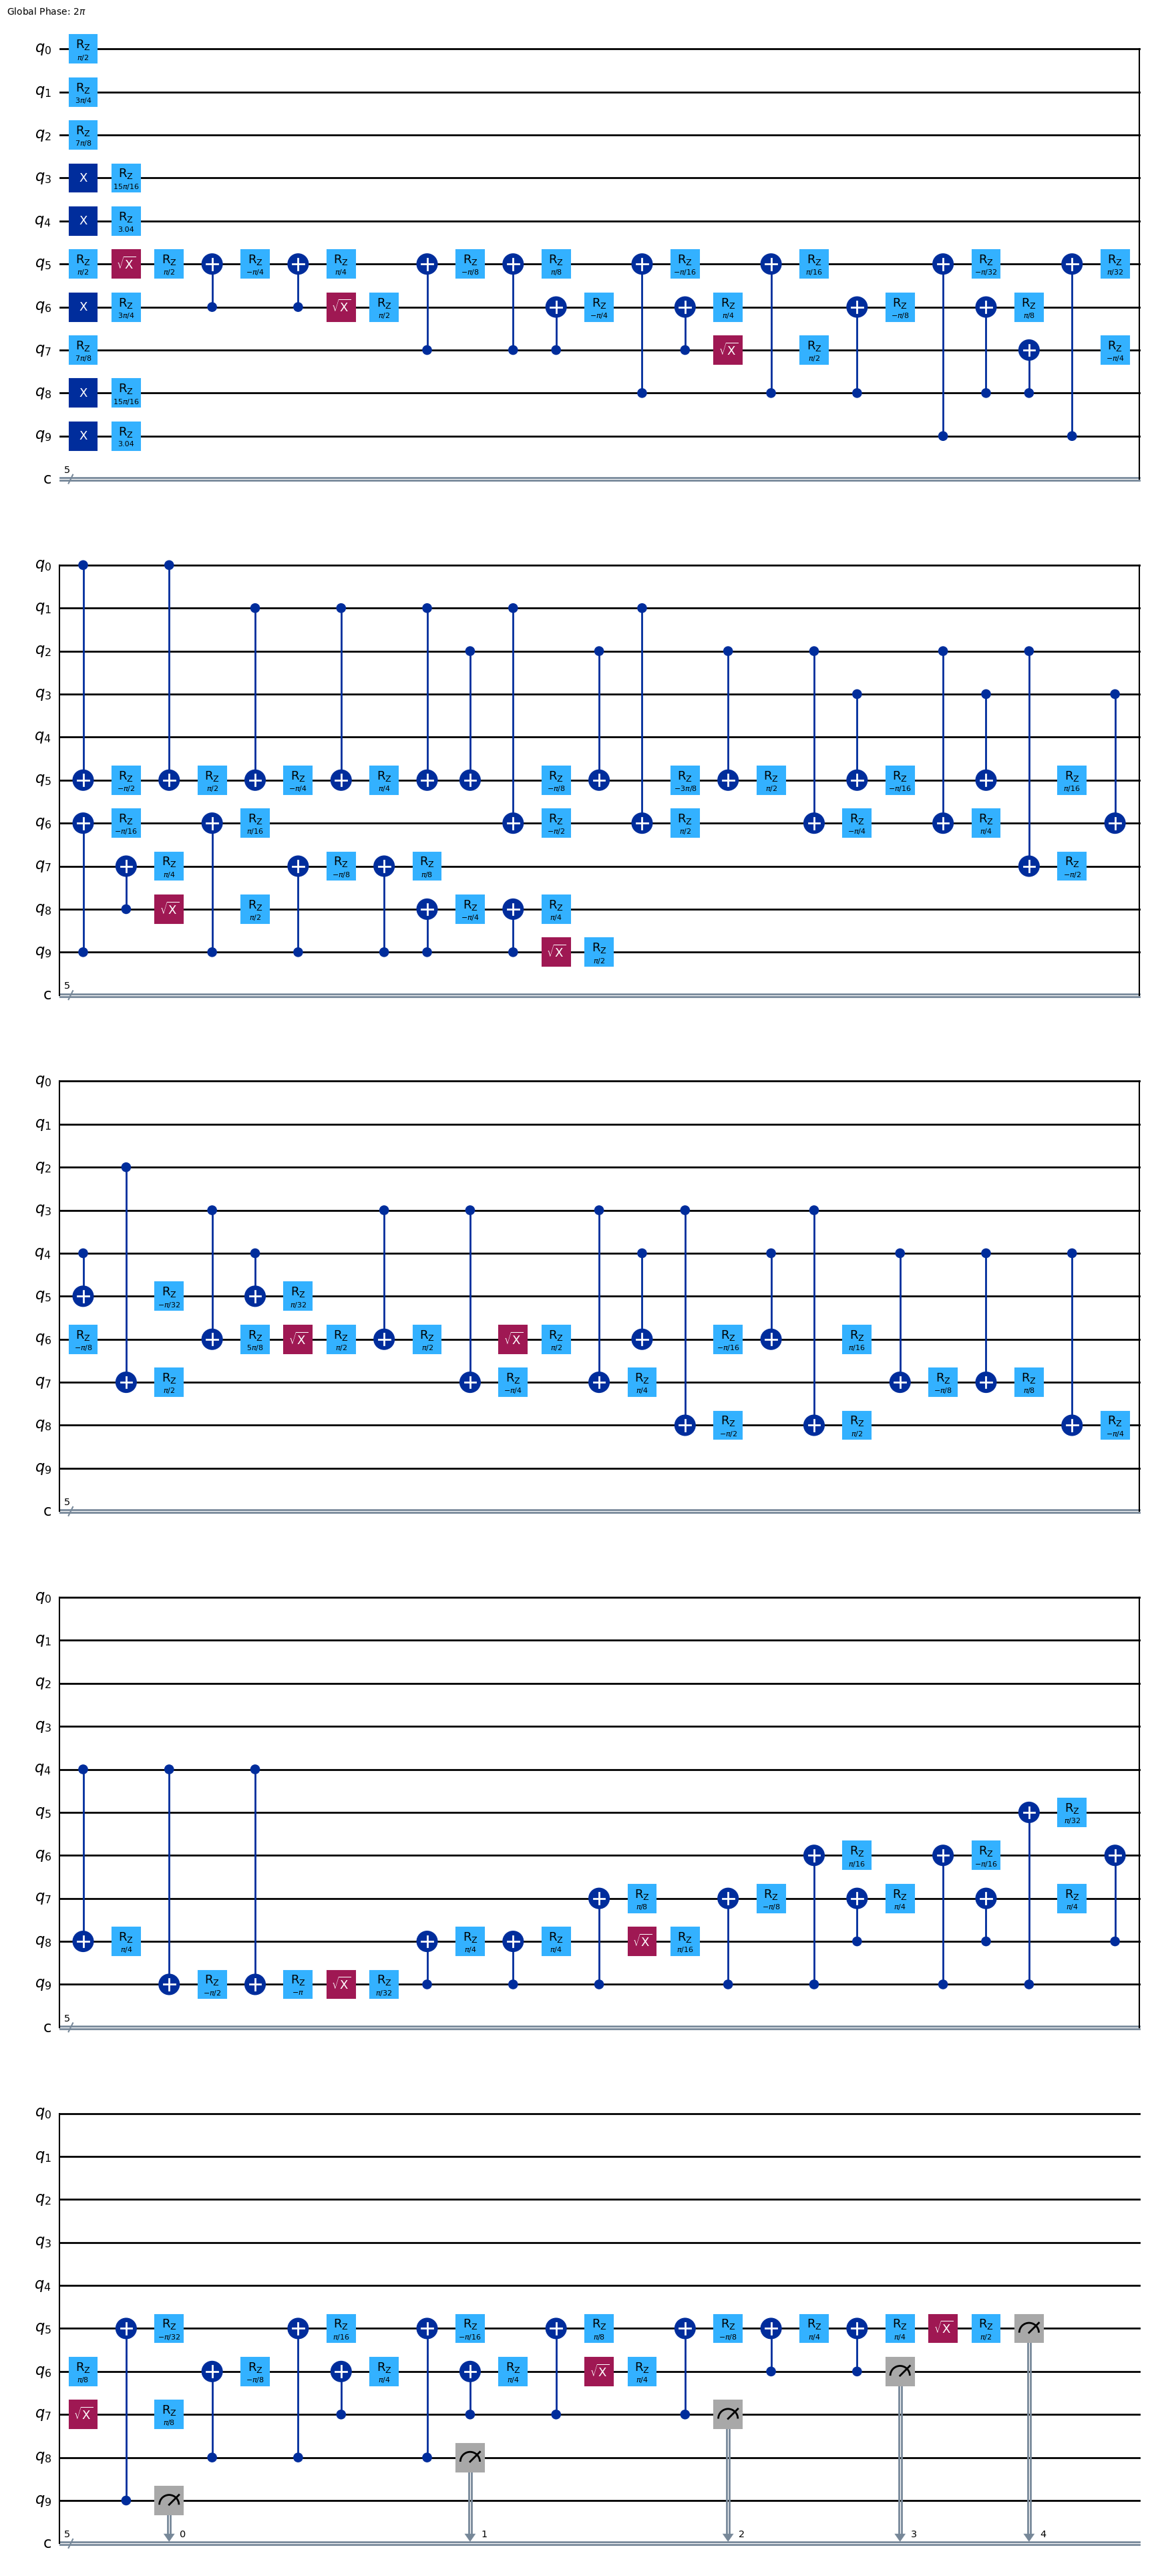

In [91]:
transpiled2.draw('mpl')

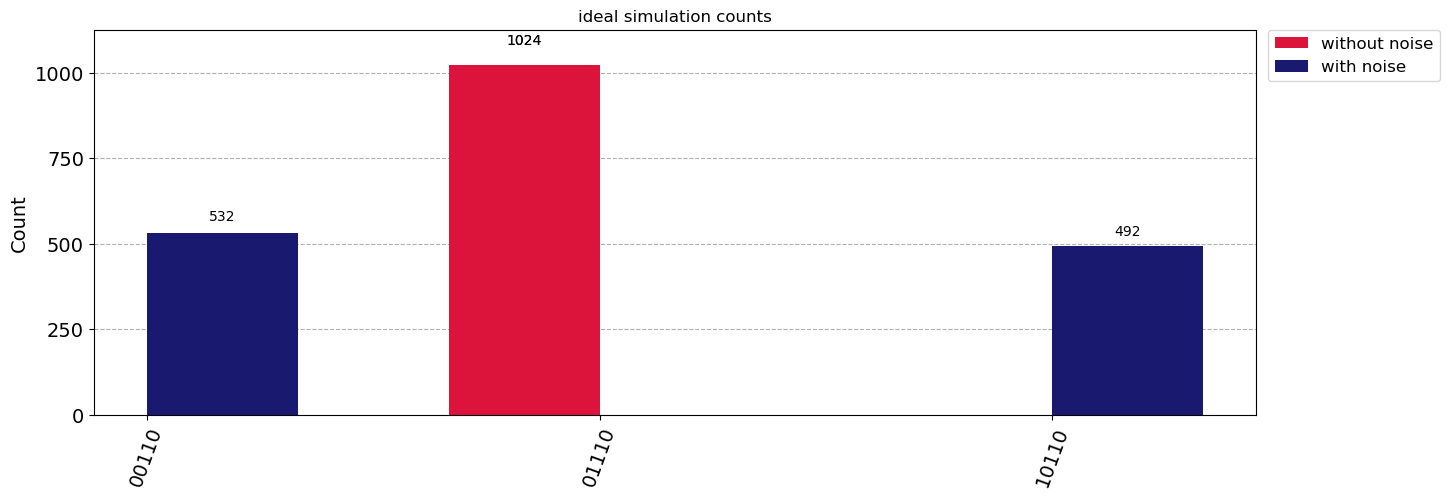

In [92]:
from qiskit_aer import AerSimulator, StatevectorSimulator, Aer

sim = AerSimulator()

transpiled1 = transpile(ideal, sim, basis_gates=basis, optimization_level=2)
transpiled2 = transpile(with_noise, sim, basis_gates=basis, optimization_level=2)

result1 = sim.run(transpiled1).result()
result2 = sim.run(transpiled2).result()

counts_ideal = result1.get_counts()
counts_noise = result2.get_counts()

plot_histogram([counts_ideal,counts_noise], color=['crimson','midnightblue'], figsize=(15,5), legend = ['without noise','with noise'], title= "ideal simulation counts")

In [94]:
ideal_state = Statevector.from_label('0' * quantum_sum(25, 38, 6).num_qubits)
ideal_state = ideal_state.evolve(quantum_sum(25, 38, 6))

#sanity check
np.array(ideal_state) == np.ones(np.array(ideal_state).shape)

array([False, False, False, ..., False, False, False])

In [95]:
noise_state = Statevector.from_label('0' * quantum_sum(25, 38, 6).num_qubits)
noise_state = noise_state.evolve(add_noise(quantum_sum(25, 38, 6), alpha=0.4, beta=0.27, n=6))

In [98]:
fidelity = state_fidelity(ideal_state, noise_state)
fidelity

2.8965652135618444e-37

# Scaling effects of noise

In [327]:
[num1,num2] = np.random.choice(50,2)
reqd_bits = len(format(num1+num2,'b'))
num1, num2, reqd_bits

(39, 11, 6)

In [328]:
ideal = quantum_sum(num1, num2, reqd_bits)
ideal_state = Statevector.from_label('0' * quantum_sum(25, 38, 6).num_qubits)
ideal_state = ideal_state.evolve(ideal)

ramp_n = 12
alphas = np.linspace(0, .4, ramp_n)
betas = np.linspace(0, .25, ramp_n)

In [332]:
xaxis = [f"{"{:.2f}".format(alphaval)},{"{:.2f}".format(betaval)}" for alphaval,betaval in zip(alphas,betas)]
xs = [xaxis]*trials
xs = np.array(xs)

trials = 4
ys = []
for _ in range(trials):
    fidelities = []

    for alpha, beta in zip(alphas, betas):
        noise_state = Statevector.from_label('0' * ideal.num_qubits)
        noise_state = noise_state.evolve(add_noise(ideal, alpha, beta, n=reqd_bits))

        fidelity = state_fidelity(ideal_state, noise_state)
        fidelities.append(fidelity)

    ys.append(np.array(fidelities))
ys = np.array(ys)

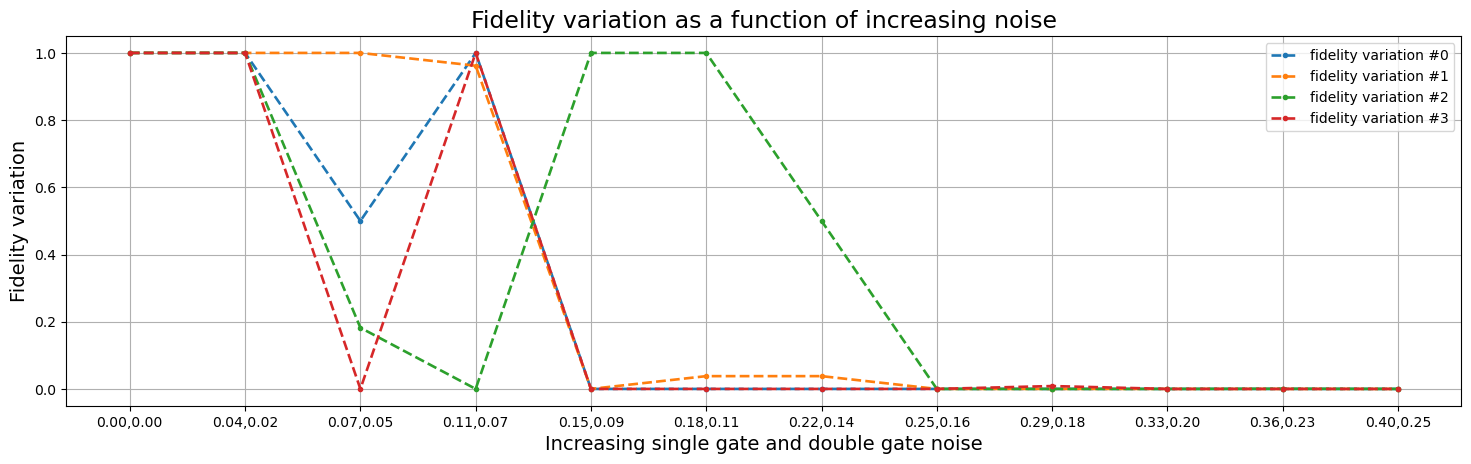

In [333]:
plt.figure().set_figwidth(18)
plt.grid()
for trial in range(trials):
    plt.plot(xs[trial],ys[trial],marker = ".",ls = "--",lw= "1.9",label = f"fidelity variation #{trial}")
plt.title("Fidelity variation as a function of increasing noise",fontsize = 17)
plt.xlabel('Increasing single gate and double gate noise',fontsize = 14)
plt.ylabel('Fidelity variation',fontsize = 14)
plt.legend()
plt.show()

#### Area of interest : alpha = (0.04,0.15), beta = (0.02,0.09)

In [336]:
ideal = quantum_sum(num1, num2, reqd_bits)
#ideal.draw('mpl')
ideal_state = Statevector.from_label('0' * quantum_sum(25, 38, 6).num_qubits)
ideal_state = ideal_state.evolve(ideal)

ramp_n = 12
alphas = np.linspace(.04, .15, ramp_n)
betas = np.linspace(.02, .09, ramp_n)

In [337]:
fidelities = []

for alpha, beta in zip(alphas, betas):
    noise_state = Statevector.from_label('0' * ideal.num_qubits)
    noise_state = noise_state.evolve(add_noise(ideal, alpha, beta, n=reqd_bits))
    
    fidelity = state_fidelity(ideal_state, noise_state)
    fidelities.append(fidelity)

np.array(fidelities), np.array(fidelities).shape

(array([9.61939766e-01, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.78847987e-32,
        1.00000000e+00, 2.16573541e-33, 1.90301169e-02, 0.00000000e+00]),
 (12,))

In [338]:
xaxis = [f"{"{:.3f}".format(alphaval)},{"{:.3f}".format(betaval)}" for alphaval,betaval in zip(alphas,betas)]
xaxis,len(xaxis)

(['0.040,0.020',
  '0.050,0.026',
  '0.060,0.033',
  '0.070,0.039',
  '0.080,0.045',
  '0.090,0.052',
  '0.100,0.058',
  '0.110,0.065',
  '0.120,0.071',
  '0.130,0.077',
  '0.140,0.084',
  '0.150,0.090'],
 12)

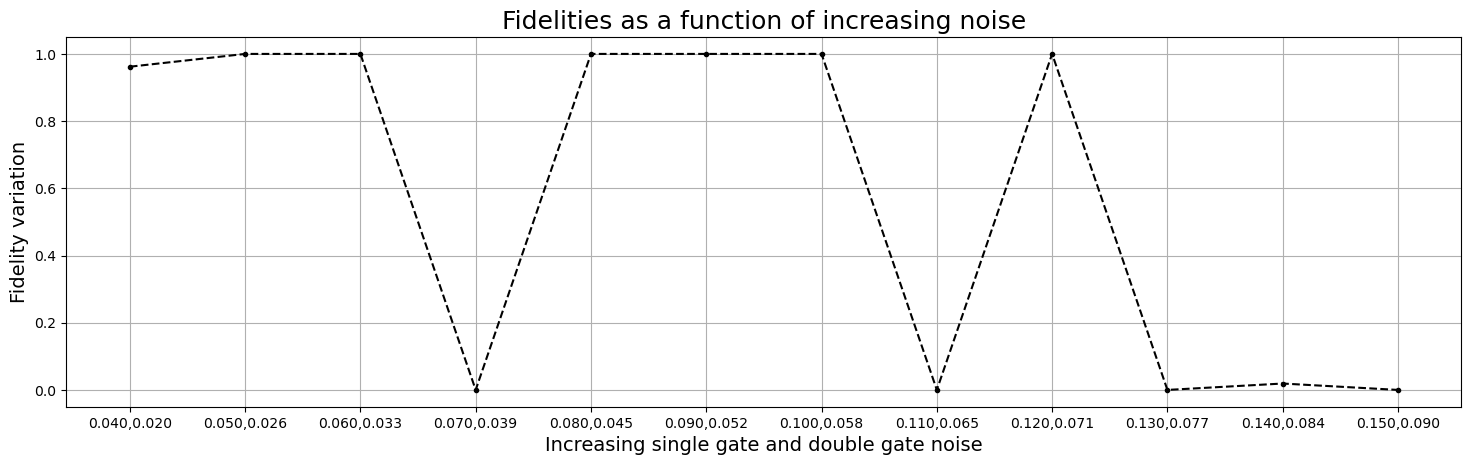

In [339]:
plt.figure().set_figwidth(18)
plt.grid()
plt.title("Fidelities as a function of increasing noise",fontsize = 18)
plt.plot(xaxis,fidelities,marker = ".",ls = "--",c="k")
plt.xlabel('Increasing single gate and double gate noise',fontsize = 14)
plt.ylabel('Fidelity variation',fontsize = 14)
plt.show()

Completely random and erratic in this zone, inconclusive. For the overall fidelities they "seem" to decrease with increase in noise (as is naively expected) but still mostly inconclusive.

# Questions :

### 1. How does noise affect the results?

Noise in quantum computations distorts the intended operations, leading to deviations in statevector fidelity and inaccurate measurement outcomes. Each gate, especially two-qubit gates, introduces errors that accumulate throughout the circuit, amplifying the impact of noise on the final results. Mitigating noise is essential to maintain reliable computations and accurate results.

For our purposes the above analyses answer the question.

### 2. Is there a way to decrease noise?

1. To address noise in QPU-transpiled circuits, employ circuit optimization and error mitigation techniques tailored to the hardware's topology. Key strategies include gate reduction, native gate decomposition directly translate circuits into the QPU's native gate set to reduce redundant operations, and methods like **Zero-Noise Extrapolation (ZNE)** to estimate low-noise results, preserving fidelity and improving measurement accuracy.  

---

2. **Dynamical Decoupling (DD)** reduces decoherence at the hardware level, and intelligent qubit mapping minimizes two-qubit gate errors by optimizing qubit placement on the QPU. Intelligent qubit mapping places logical qubits on physically closer QPU qubits, reducing long-distance two-qubit gates that amplify noise. Combined with layout optimization during transpilation, this approach ensures that the circuit respects hardware-specific connectivity, decreasing two-qubit gate errors and enhancing overall circuit performance.  

### 3. How does the number of gates affect the amount of noise? 

The number of gates directly correlates with noise levels, as each gate introduces errors that accumulate throughout the circuit. Two-qubit gates are particularly error-prone, so circuits with many such gates experience higher noise. Optimizing gate sequences and minimizing gate count are crucial for reducing overall noise in quantum computations.